# Installations

In [ ]:
! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

# Imports

In [2]:
import clip
import torch 
import torch.nn as nn
from PIL import Image
import pandas as pd
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as tf
import torchvision.transforms.functional as TF
import random
import skimage.io as io
import matplotlib.pyplot as plt
import json
import datetime
import copy
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import Levenshtein
from collections import defaultdict
from itertools import combinations
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torch.nn.functional as F

# Loading CLIP model

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess = clip.load('ViT-L/14@336px', device)

100%|███████████████████████████████████████| 891M/891M [00:16<00:00, 58.3MiB/s]


# Annotations Loader Class

In [5]:
class VQA_annotations_loader:
    def __init__(self, annotation_file=None):
        # load dataset
        self.dataset = {}
        self.imgToQA = {}
        if annotation_file != None:
            print('loading dataset into memory...')
            time_t = datetime.datetime.utcnow()
            dataset = json.load(open(annotation_file, 'r'))
            print(datetime.datetime.utcnow() - time_t)
            self.dataset = dataset
            self.imgToQA = {x['image']:x for x in dataset}

    def getImgs(self):
        return list(self.imgToQA.keys())

    def getAnns(self, imgs=[], ansTypes=[]):
        anns = self.dataset
        imgs = imgs if type(imgs) == list else [imgs]
        if len(imgs) != 0:
            anns = [self.imgToQA[img] for img in imgs]
        ansTypes  = ansTypes  if type(ansTypes)  == list else [ansTypes]
        if len(ansTypes) != 0:
            anns = [ann for ann in anns if ann['answer_type'] in ansTypes]
        return anns

    def showQA(self, anns):
        if len(anns) == 0:
            return 0
        for ann in anns:
            print("Question: %s"%ann['question'])
            print("Answer: ")
            print('\n'.join([x['answer'] for x in ann['answers']]))

## Random Question/Image Pair Display with answer

Training Annotations
loading dataset into memory...
0:00:00.342558

Validation Annotations
loading dataset into memory...
0:00:00.055860

Show a random sample from training data
Question: Is this shampoo please?
Answer: 
no
no
unsuitable
unanswerable
unsuitable
no
no
unanswerable
no
no


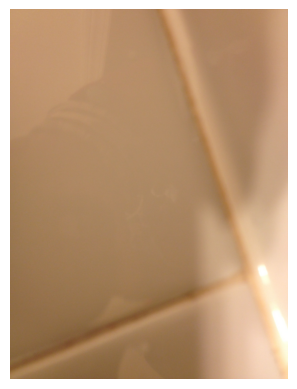

In [6]:
annFile_train='/kaggle/input/vizwiz/data/Annotations/train.json'
annFile_val = '/kaggle/input/vizwiz/data/Annotations/val.json'
imgDir = '/kaggle/input/vizwiz/data/Images/'

print("Training Annotations")
vqa_train = VQA_annotations_loader(annFile_train)
print("\nValidation Annotations")
vqa_val = VQA_annotations_loader(annFile_val)

print("\nShow a random sample from training data")
anns_train = vqa_train.getAnns(ansTypes='yes/no')
randomAnn = random.choice(anns_train)
vqa_train.showQA([randomAnn])
imgFilename = randomAnn['image']

if os.path.isfile(imgDir + imgFilename):
	I = io.imread(imgDir + imgFilename)
	plt.imshow(I)
	plt.axis('off')
	plt.show()

## Get all annotations


In [7]:
all_anns_train = vqa_train.getAnns()
all_anns_val = vqa_val.getAnns()

## Extract the answer counts


In [8]:
answer_type_counts = {}
answerability_counts = {}
answer_conf_counts = {}
for ann in all_anns_train:
    
        answer_type = ann['answer_type']
        answerable = ann['answerable']
        
        
        if answer_type in answer_type_counts:
            answer_type_counts[answer_type] += 1
        else:
            answer_type_counts[answer_type] = 1
            
            
            
        if answerable in answerability_counts:
            answerability_counts[answerable] += 1
        else:
            answerability_counts[answerable] = 1
            
        
        
        for answer in ann['answers']:
            answer_conf = answer ['answer_confidence']
            if answer_conf in answer_conf_counts:
                answer_conf_counts[answer_conf] += 1
            else:
                answer_conf_counts[answer_conf] = 1

## Plot the Analysis Bar Charts


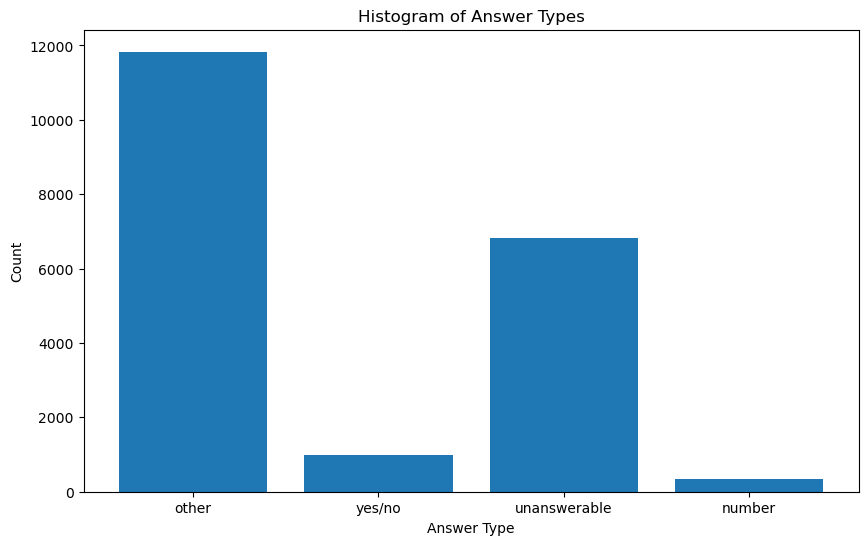

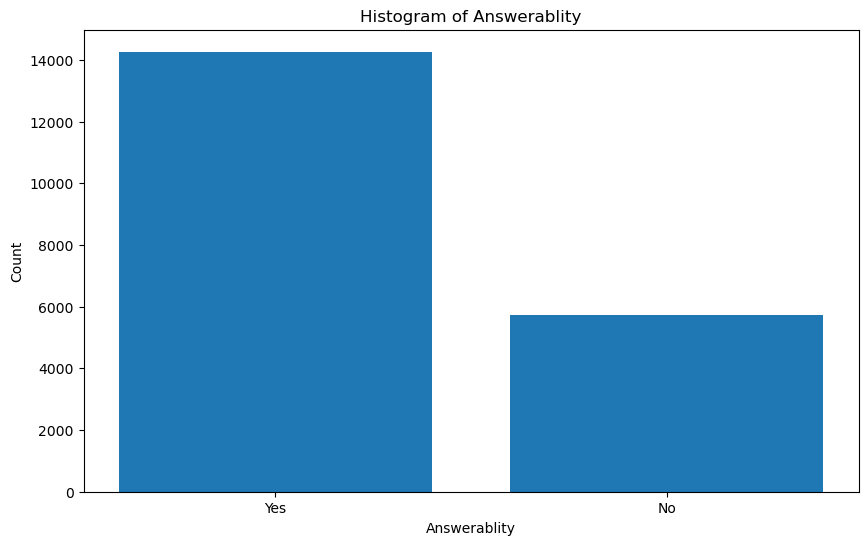

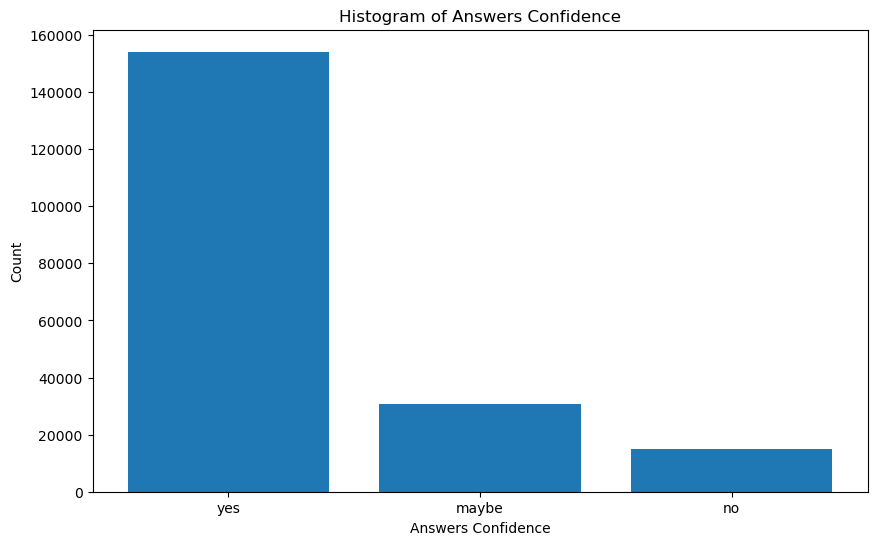

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(answer_type_counts.keys(), answer_type_counts.values())
plt.xlabel('Answer Type')
plt.ylabel('Count')
plt.title('Histogram of Answer Types')
plt.show()    

plt.figure(figsize=(10, 6))
plt.bar(['Yes', 'No'], answerability_counts.values())
plt.xlabel('Answerablity')
plt.ylabel('Count')
plt.title('Histogram of Answerablity')
plt.show()  

plt.figure(figsize=(10, 6))
plt.bar(answer_conf_counts.keys(), answer_conf_counts.values())
plt.xlabel('Answers Confidence')
plt.ylabel('Count')
plt.title('Histogram of Answers Confidence')
plt.show()  
    

# Dataset Class

In [10]:
class MyDataset(Dataset):
    def __init__(self, file, RAM_batch_size, answer, answer_type, answerability):
        self.file = file
        self.RAM_batch_size = RAM_batch_size
        self.answer = answer
        self.answer_type = answer_type
        self.answerability = answerability

        # Read the HDF5 file
        self.read_df = pd.read_hdf(self.file, key='data')
        self.file_size = self.read_df.shape[0]

        # Initialize RAM batch
        self.current_index = 0
        self.batch_start = 0
        self.batch_end = min(self.RAM_batch_size, self.file_size)
        self.load_batch()
        print(self.file_size)

    def load_batch(self):
        # Load a batch of data from the file to RAM
        desired_list = self.read_df.loc[self.batch_start:self.batch_end - 1]['embeddings']
        self.data = torch.tensor(desired_list.tolist())

    def __len__(self):
        return self.file_size
    

    def __getitem__(self, index):
        if index == 0:
            self.current_index = 0
            self.batch_start = 0
            self.batch_end = min(self.RAM_batch_size, self.file_size)
            self.load_batch()
            
        if index >= self.batch_end:
            # Update RAM batch
            self.current_index = index
            self.batch_start = index
            self.batch_end = min(index + self.RAM_batch_size, self.file_size)
            self.load_batch()

        # Retrieve data from the RAM batch
        batch_index = index - self.batch_start  # Adjust index relative to the RAM batch
        reshaped_tensor = self.data[batch_index]
        reshaped_tensor = reshaped_tensor.view(1, 1536).to(device)
        return reshaped_tensor, self.answer[index], self.answer_type[index], self.answerability[index]

# Data Extraction From Annotations

In [11]:
answer_types = []
answers_array = []
answerability = []

for a in all_anns_train:
    answerability.append(a['answerable'])
    answer_types.append(a['answer_type'])
    answers = a['answers']
    
    answer_counts = {}
    for answer in answers:
        answer_text = answer['answer']
        if answer_text in answer_counts:
            answer_counts[answer_text] += 1
        else:
            answer_counts[answer_text] = 1
    
    max_count = max(answer_counts.values())
    majority_answers = [answer for answer, count in answer_counts.items() if count == max_count]
    
    # Handle ties using Levenshtein distance
    if len(majority_answers) > 1:
        min_distance = float('inf')
        selected_answer = None
        
        # Find the most representative answer based on Levenshtein distance
        for answer_pair in combinations(majority_answers, 2):
            distance = Levenshtein.distance(answer_pair[0], answer_pair[1])
            if distance < min_distance:
                min_distance = distance
                selected_answer = min(answer_pair, key=len)
        
        answers_array.append(selected_answer)
        
    else:
        answers_array.append(majority_answers[0])

        
for a in all_anns_val:
    answerability.append(a['answerable'])
    answer_types.append(a['answer_type'])
    answers = a['answers']

    answer_counts = {}
    for answer in answers:
        answer_text = answer['answer']
        if answer_text in answer_counts:
            answer_counts[answer_text] += 1
        else:
            answer_counts[answer_text] = 1
    
    max_count = max(answer_counts.values())
    majority_answers = [answer for answer, count in answer_counts.items() if count == max_count]
    
    # Handle ties using Levenshtein distance
    if len(majority_answers) > 1:
        min_distance = float('inf')
        selected_answer = None
        
        # Find the most representative answer based on Levenshtein distance
        for answer_pair in combinations(majority_answers, 2):
            distance = Levenshtein.distance(answer_pair[0], answer_pair[1])
            if distance < min_distance:
                min_distance = distance
                selected_answer = min(answer_pair, key=len)
        
        answers_array.append(selected_answer)
    
    else:
        answers_array.append(majority_answers[0])



        
# Get unique values from the answers array
all_labels = list(answers_array)
unique_answers = list(set(answers_array))
answerability = list(answerability)
unique_answer_types = list(set(answer_types))

# One Hot Encodings

In [12]:
encoder = OneHotEncoder()
encoder_types = OneHotEncoder()
all_labels = np.array(all_labels)
labels_2d = all_labels.reshape(-1, 1)
one_hot_labels = encoder.fit_transform(labels_2d)
one_hot_labels_array = one_hot_labels.toarray()
answers_one_hot =  one_hot_labels_array[:len(all_anns_train),:]
validation_answers_one_hot =  one_hot_labels_array[len(all_anns_train):,:]


answer_types = np.array(answer_types)
answer_types_2d = answer_types.reshape(-1, 1)
one_hot_answer_types = encoder_types.fit_transform(answer_types_2d)
answer_types_one_hot = one_hot_answer_types.toarray()
train_answer_types_one_hot =  answer_types_one_hot[:len(all_anns_train),:]
validation_answer_types_one_hot =  answer_types_one_hot[len(all_anns_train):,:]



train_answerability = answerability[:len(all_anns_train)]
val_answerability = answerability[len(all_anns_train):]

# Encoding The Dataset

## Encoding the Training Data

In [ ]:
n = len(all_anns_train)
print(n)
img_dir = '/kaggle/input/vizwiz/data/Images/'
rotate = False
concatinated_features_train = []
for index in range(n):
    image_id = all_anns_train[index]['image']
    image_path = img_dir + image_id

    question = all_anns_train[index]['question']
    image = Image.open(image_path)  

    if rotate:
        augmented_image = image.rotate(90.0)
        augmented_image_input = preprocess(augmented_image).unsqueeze(0).to(device)

    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(question)]).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model_clip.encode_image(image_input)
        text_features = model_clip.encode_text(text_inputs)
        if rotate:
            augmented_image_features = model_clip.encode_image(augmented_image_input)


    concatenated_features = torch.cat((image_features, text_features), dim=1)
    if rotate:
        augmented_concatenated_features = torch.cat((augmented_image_features, text_features), dim=1)
        concatenated_features = torch.cat((concatenated_features, augmented_concatenated_features), dim=0)
    concatinated_features_train.append(concatenated_features)

20000


## Encoding the Validation Data

In [17]:
n = len(all_anns_val)
img_dir = '/kaggle/input/vizwiz/data/Images/'
concatinated_features_val = []
for index in range(n):
    image_id = all_anns_val[index]['image']
    image_path = img_dir + image_id

    question = all_anns_val[index]['question']
    image = Image.open(image_path)  

    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(question)]).to(device)
    # Calculate features
    with torch.no_grad():
        image_features = model_clip.encode_image(image_input)
        text_features = model_clip.encode_text(text_inputs)
    concatenated_features = torch.cat((image_features, text_features), dim=1)
    concatinated_features_val.append(concatenated_features)

# Splitting

In [18]:
labels_combined = list(zip(answers_one_hot,train_answer_types_one_hot,train_answerability))
print(len(labels_combined))
print(len(concatinated_features_train))
x_train, x_test, y_train, y_test = train_test_split(concatinated_features_train, labels_combined, test_size=0.05, random_state=42, stratify = train_answer_types_one_hot)
train_answers, train_answer_types, train_answerability = zip(*y_train)
test_answers, test_answer_types, test_answerability  = zip(*y_test)
print(len(y_train))
print(len(x_train))

400
400
380
380


## Saving Data in hd_Files 

In [19]:
train_df = pd.DataFrame()
train=[]
train_df = pd.DataFrame({'embeddings': [row.detach().cpu().numpy().tolist() for row in x_train]})
train_df.to_hdf('train_df.h5', key='data', format='fixed')

val_df = pd.DataFrame()
val=[]
val_df = pd.DataFrame({'embeddings': [row.detach().cpu().numpy().tolist() for row in concatinated_features_val]})
val_df.to_hdf('val_df.h5', key='data', format='fixed')

test_df = pd.DataFrame()
test=[]
test_df = pd.DataFrame({'embeddings': [row.detach().cpu().numpy().tolist() for row in x_test]})
test_df.to_hdf('test_df.h5', key='data', format='fixed')

/tmp/ipykernel_70/2269318456.py:4: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['embeddings'], dtype='object')]

  train_df.to_hdf('train_df.h5', key='data', format='fixed')
/tmp/ipykernel_70/2269318456.py:9: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['embeddings'], dtype='object')]

  val_df.to_hdf('val_df.h5', key='data', format='fixed')
/tmp/ipykernel_70/2269318456.py:14: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['embeddings'], dtype='object')]

  test_df.to_hdf('test_df.h5', key='data', format='fixed')


In [20]:
class VQAModel(torch.nn.Module):
    def __init__(self):
        super(VQAModel,self).__init__()
        n_ans_classes = one_hot_labels_array.shape[1]
        n_aux_classes = 4

        self.ln1 = torch.nn.LayerNorm(768 * 2)
        self.dp1 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(768 * 2, 768)

        self.ln2 = torch.nn.LayerNorm(768)
        self.dp2 = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(768, n_ans_classes)
        
        self.fc_aux = torch.nn.Linear(768, n_aux_classes)
        self.fc_gate = torch.nn.Linear(n_aux_classes, n_ans_classes)
        self.act_gate = torch.nn.Sigmoid()
        

    def forward(self, features):
        x = self.ln1(features.float())
        x = self.dp1(x)
        x = self.fc1(x)  # 768
        
        aux = self.fc_aux(x) # 4

        gate = self.fc_gate(aux)
        gate = self.act_gate(gate) # 5332
         
        x = self.ln2(x) 
        x = self.dp2(x)
        vqa = self.fc2(x) #768 --> 5332
        
        output = vqa * gate # element-wise multiplication
        
        return output, aux    

In [21]:
def run_model(model,dataloader, optimizer,train = True ):
    if train:
        model.train()
    loss = nn.CrossEntropyLoss()
    total_loss_number = 0
    answers_predictions = []
    ground_truth_answer = []
    
    for (data, answer, answer_type, _) in train_dataloader:
        for i in range(data.size()[1]):
            output_ans, output_aux = model(data[:, i:i+1, :])
            output_ans = output_ans.squeeze(dim=1)
            output_ans = output_ans.double().to(device)
            answer= answer.double().to(device)
            output_aux = output_aux.squeeze(dim=1)
            output_aux = output_aux.double().to(device)
            loss_ans = loss(output_ans, answer)
            loss_aux =  loss(output_aux, answer_type.to(device))
            total_loss_number += loss_ans.item() + loss_aux.item()      
            answers_predictions += output_ans.tolist()
            ground_truth_answer += answer.tolist()

            if train:
                optimizer.zero_grad()
                total_loss = loss_ans + loss_aux
                total_loss.backward()
                optimizer.step()


    return answers_predictions, ground_truth_answer, total_loss_number / len(train_dataloader)

# Main Code

In [27]:
RAM_batch_size = 3000
trainDataset=MyDataset('train_df.h5',RAM_batch_size, train_answers, train_answer_types, train_answerability)
train_dataloader = DataLoader(trainDataset, batch_size=4, shuffle=False, num_workers=0)     

380


In [23]:
valDataset=MyDataset('val_df.h5',RAM_batch_size, validation_answers_one_hot, validation_answer_types_one_hot, val_answerability)
val_dataloader = DataLoader(valDataset, batch_size=4, shuffle=False, num_workers=0)   

200


In [24]:
testDataset=MyDataset('test_df.h5',RAM_batch_size, test_answers, test_answer_types, test_answerability)
test_dataloader = DataLoader(testDataset, batch_size=4, shuffle=False, num_workers=0)   

20


# Training and Validation



Epoch # 1
Training Loss =  6.906689460755423
Training Accuracy =  0.2631578947368421 %


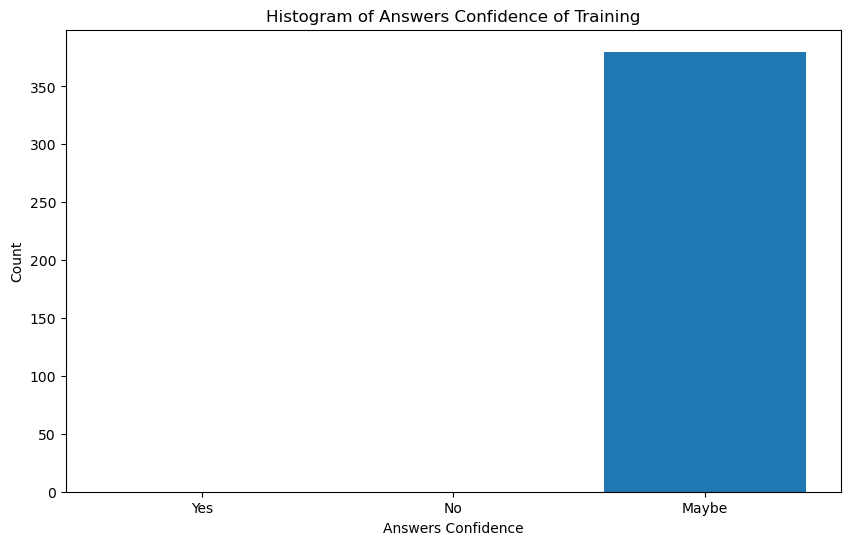


Validation Loss =  6.496942662815124
Validation Accuracy =  2.8947368421052633 %


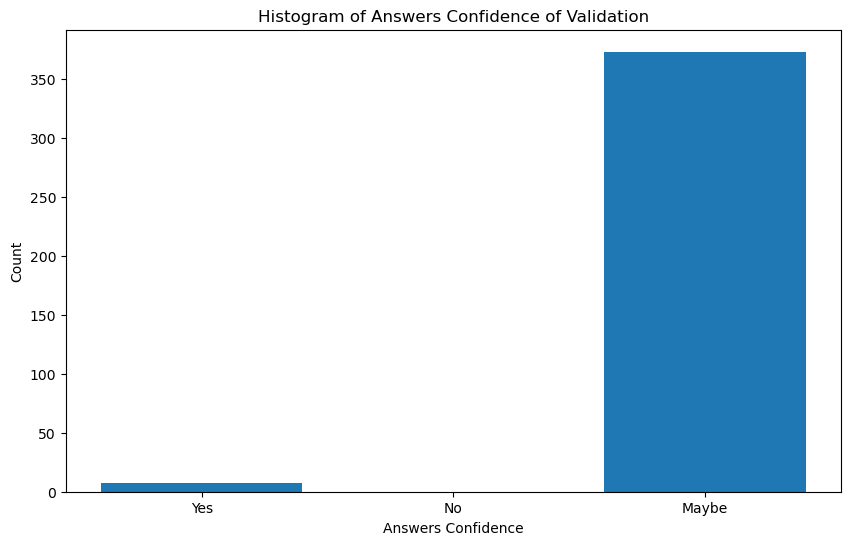



Epoch # 2
Training Loss =  6.395870176360456
Training Accuracy =  6.578947368421052 %


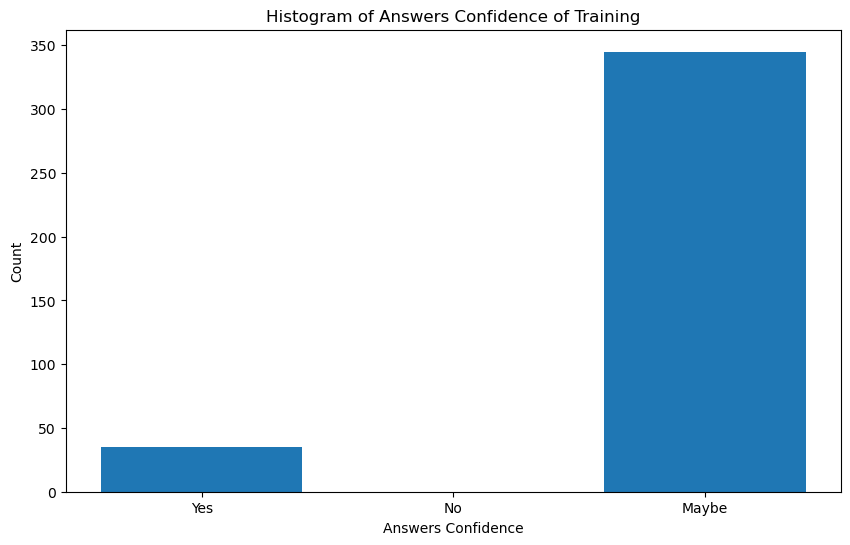


Validation Loss =  6.174253436298325
Validation Accuracy =  11.31578947368421 %


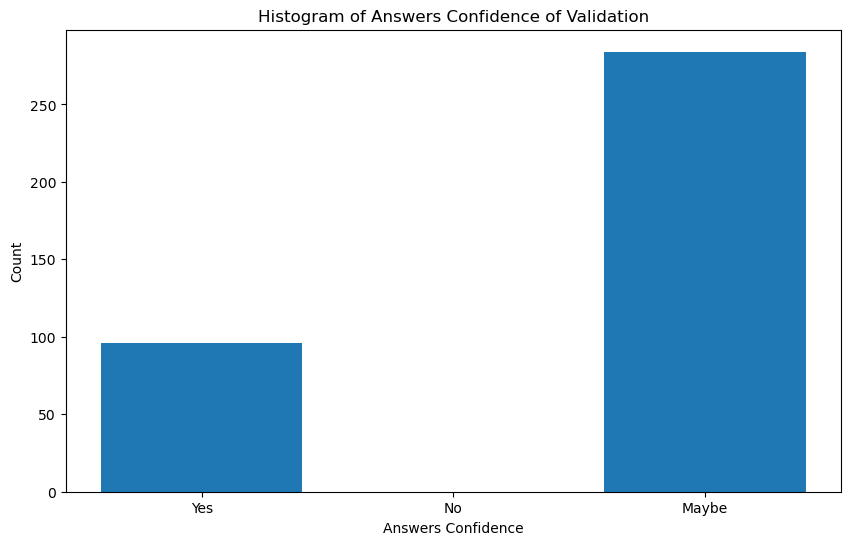



Epoch # 3
Training Loss =  6.092304693942038
Training Accuracy =  14.473684210526317 %


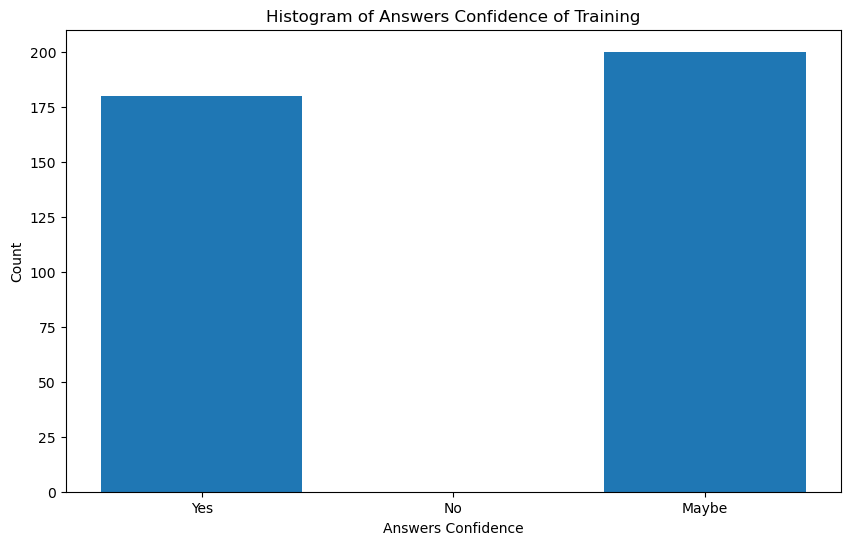


Validation Loss =  5.969674270559805
Validation Accuracy =  15.789473684210526 %


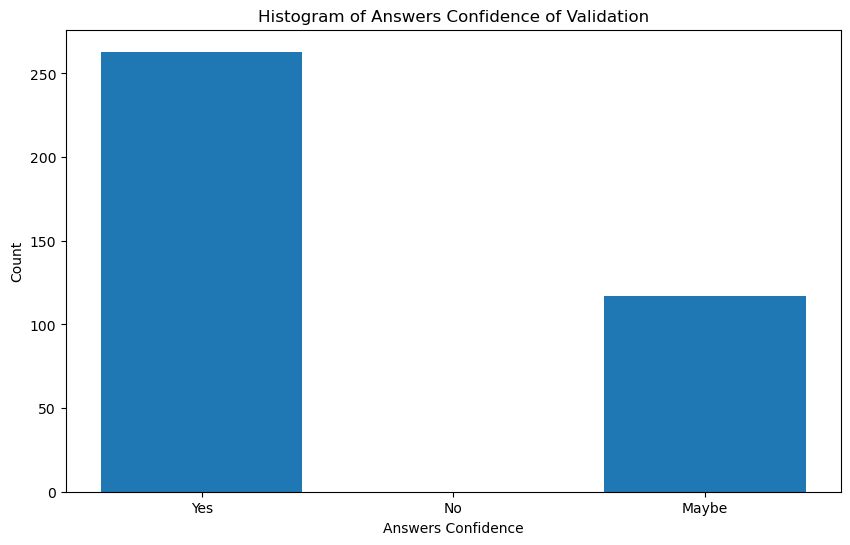



Epoch # 4
Training Loss =  5.853254873637133
Training Accuracy =  17.105263157894736 %


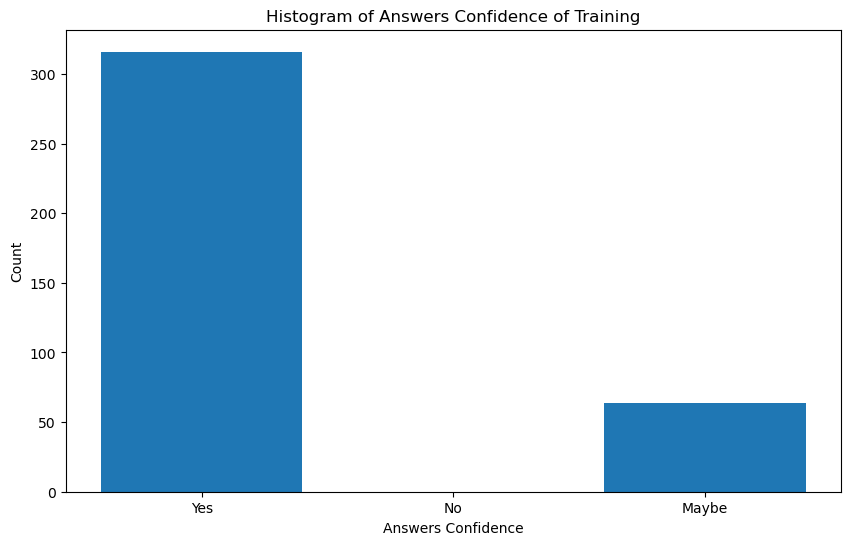


Validation Loss =  5.75459845089148
Validation Accuracy =  17.894736842105264 %


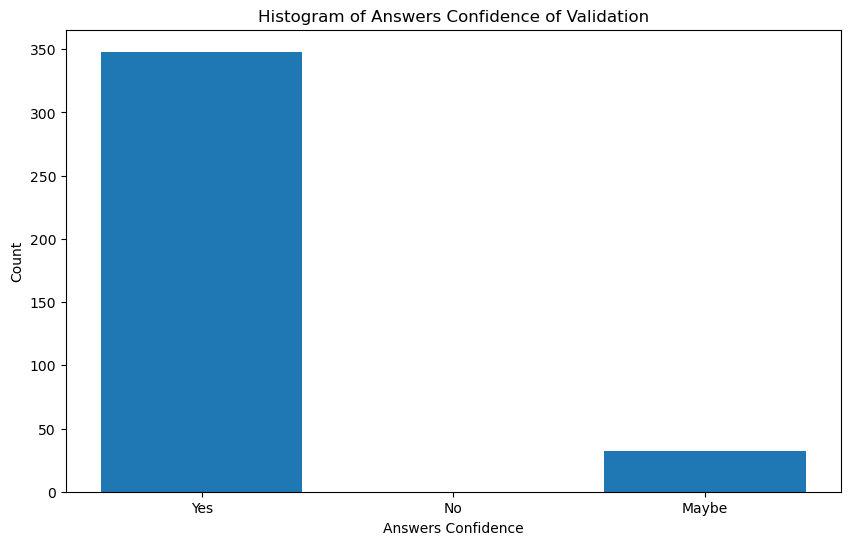



Epoch # 5
Training Loss =  5.692093015861337
Training Accuracy =  17.894736842105264 %


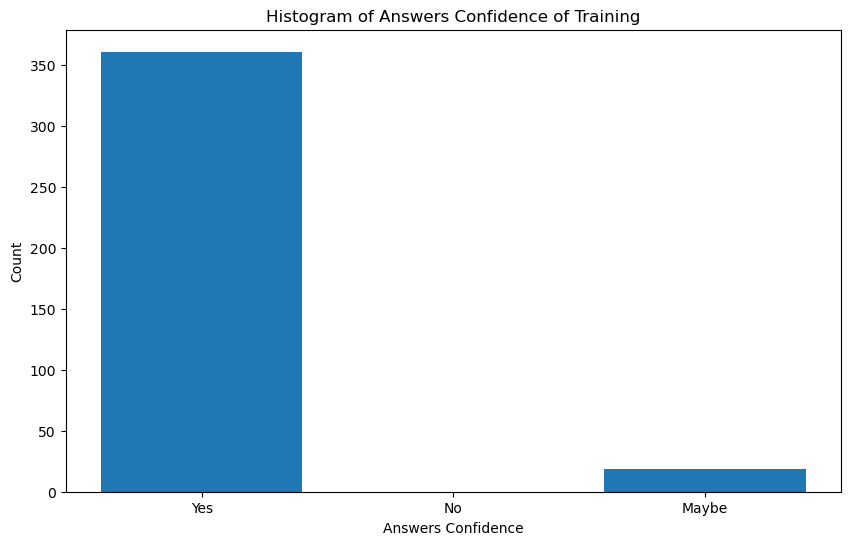


Validation Loss =  5.658427372087187
Validation Accuracy =  17.36842105263158 %


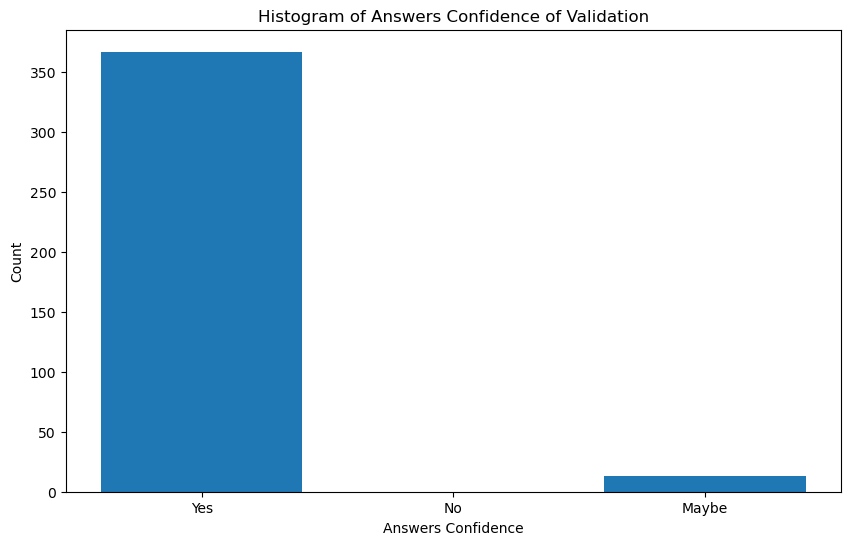

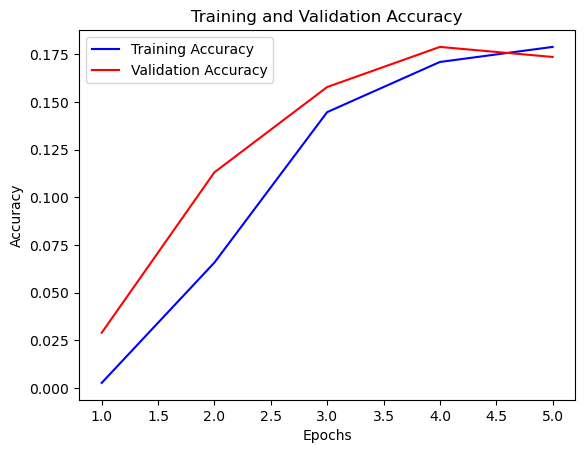

In [25]:
model = VQAModel().to(device)
epoch = 5
optimizer = torch.optim.Adam(model.parameters(), 0.00001, weight_decay=.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.3, threshold=1e-4)
import torch
import torch.nn.functional as F
train_accuracy_per_epoch = []
train_loss_per_epoch = []

val_accuracy_per_epoch = []
val_loss_per_epoch = []

for e in range(epoch):
    print("\n\nEpoch #", e+1)
    count_train = 0
    count_val = 0
    yes_count_train = no_count_train = count_maybe_train = 0
    yes_count_val = no_count_val = count_maybe_val = 0
    answers_predictions_train, ground_truth_answer_train, loss_train = run_model(model,train_dataloader,optimizer,True)
    answers_predictions_val, ground_truth_answer_val, loss_val = run_model(model,val_dataloader,optimizer,False)

    print("Training Loss = ", loss_train)
    
    # Loop for Training
    for i in range (len(answers_predictions_train)):
        answers_predictions_tensor_train = torch.tensor(answers_predictions_train[i])
        output_tensor_train = F.softmax(answers_predictions_tensor_train, dim=0)
        mean = output_tensor_train.mean()
        max_index = torch.argmax(output_tensor_train).item()
        if output_tensor_train[max_index] >= (mean + 0.02):
            yes_count_train = yes_count_train + 1
        elif output_tensor_train[max_index] <= (mean - 0.005):
            no_count_train = no_count_train + 1     
        else: 
            count_maybe_train = count_maybe_train + 1
        true_index = ground_truth_answer_train[i].index(1.0)
        if true_index == max_index:
            count_train = count_train + 1
    train_accuracy = count_train/len(answers_predictions_train)
    print("Training Accuracy = ", train_accuracy*100, '%')   
    train_accuracy_per_epoch.append(train_accuracy)
    train_loss_per_epoch.append(loss_train)
    # Plot the barchart
    plt.figure(figsize=(10, 6))
    plt.bar(['Yes','No', 'Maybe'], [yes_count_train, no_count_train, count_maybe_train])
    plt.xlabel('Answers Confidence')
    plt.ylabel('Count')
    plt.title('Histogram of Answers Confidence of Training')
    plt.show()  

    
    
    print("\nValidation Loss = ", loss_val)
    # Loop for validation
    for i in range (len(answers_predictions_val)):
        answers_predictions_tensor_val = torch.tensor(answers_predictions_val[i])
        output_tensor_val = F.softmax(answers_predictions_tensor_val, dim=0)
        max_index = torch.argmax(output_tensor_val).item()
        true_index = ground_truth_answer_val[i].index(1.0)
        mean = output_tensor_val.mean()
        if output_tensor_val[max_index] >= (mean + 0.02):
            yes_count_val = yes_count_val + 1
        elif output_tensor_val[max_index] <= (mean - 0.0005):
            no_count_val = no_count_val + 1     
        else: 
            count_maybe_val = count_maybe_val + 1
        if true_index == max_index:
            count_val = count_val + 1
    val_accuracy = count_val/len(answers_predictions_val)
    print("Validation Accuracy = ", val_accuracy*100, '%')   
    val_accuracy_per_epoch.append(val_accuracy)
    val_loss_per_epoch.append(loss_val)
     # Plot the barchart
    plt.figure(figsize=(10, 6))
    plt.bar(['Yes','No', 'Maybe'], [yes_count_val, no_count_val, count_maybe_val])
    plt.xlabel('Answers Confidence')
    plt.ylabel('Count')
    plt.title('Histogram of Answers Confidence of Validation')
    plt.show()


# Create a range of epochs
epochs = range(1, len(train_accuracy_per_epoch)+1)

# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy_per_epoch, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_per_epoch, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Testing

Testing Loss =  5.657145317603254
Testing Accuracy =  17.63157894736842 %


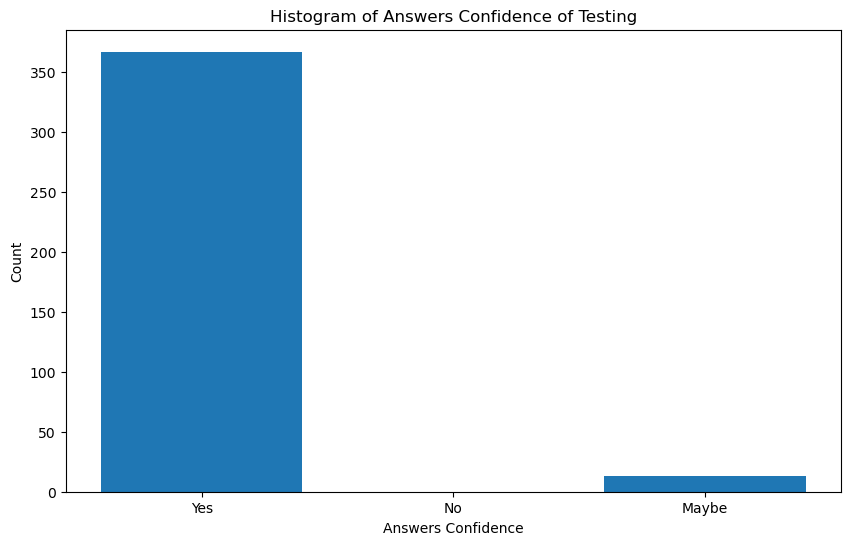

In [26]:
count_test = 0
yes_count_test = no_count_test = count_maybe_test = 0

answers_predictions_test, ground_truth_answer_test, loss_test = run_model(model,test_dataloader,optimizer,False)

print("Testing Loss = ", loss_test)

# Loop for testing
for i in range (len(answers_predictions_test)):
    answers_predictions_tensor_test = torch.tensor(answers_predictions_test[i])
    output_tensor_test = F.softmax(answers_predictions_tensor_test, dim=0)
    mean = output_tensor_test.mean()
    max_index = torch.argmax(output_tensor_test).item()
    if output_tensor_test[max_index] >= (mean + 0.02):
        yes_count_test = yes_count_test + 1
    elif output_tensor_train[max_index] <= (mean - 0.005):
        no_count_test = no_count_test + 1     
    else: 
        count_maybe_test = count_maybe_test + 1
    true_index = ground_truth_answer_test[i].index(1.0)
    if true_index == max_index:
        count_test = count_test + 1
    
    

test_accuracy = count_test/len(answers_predictions_test)
print("Testing Accuracy = ", test_accuracy*100, '%')   
plt.figure(figsize=(10, 6))
plt.bar(['Yes','No', 'Maybe'], [yes_count_test, no_count_test, count_maybe_test])
plt.xlabel('Answers Confidence')
plt.ylabel('Count')
plt.title('Histogram of Answers Confidence of Testing')
plt.show()

# Answerability Model

In [36]:
RAM_batch_size = 3000
trainDataset=MyDataset('train_df.h5',RAM_batch_size, train_answers, train_answer_types, train_answerability)
train_dataloader_ans = DataLoader(trainDataset, batch_size=4, shuffle=False, num_workers=0)     

380


In [37]:
valDataset=MyDataset('val_df.h5',RAM_batch_size, validation_answers_one_hot, validation_answer_types_one_hot, val_answerability)
val_dataloader_ans = DataLoader(valDataset, batch_size=4, shuffle=False, num_workers=0)   

200


In [38]:
testDataset=MyDataset('test_df.h5',RAM_batch_size, test_answers, test_answer_types, test_answerability)
test_dataloader = DataLoader(testDataset, batch_size=4, shuffle=False, num_workers=0)   

20


In [39]:
class AnswerabilityModel(torch.nn.Module):
    def __init__(self):
        super(AnswerabilityModel,self).__init__()

        self.ln1 = torch.nn.LayerNorm(768 * 2)
        self.dp1 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(768 * 2, 768)
        self.fc2 = torch.nn.Linear(768, 1)
        self.activation = torch.nn.Sigmoid()
        

    def forward(self, features):
        x = self.ln1(features.float())
        x = self.dp1(x)
        x = self.fc1(x)  # 768
        x = self.fc2(x)  # 1
        output = self.activation(x)    
        return output    
    

In [40]:
def run_answerability_model(model,dataloader, optimizer,train = True ):
    if train:
        model.train()
  
    loss = nn.CrossEntropyLoss()
    total_loss = 0
    ans_pred = []
    ans_ground = []
    
    for (data, _, _, answerability) in train_dataloader_ans:
        output = model(data.float())
        output = output.squeeze(dim=1)
        output = output.squeeze(dim=1)
        output = output.double().to(device)
        answerability = answerability.float().to(device)
        loss_ = loss(output, answerability)
        total_loss += loss_.item() 
        updated_list = [1 if fraction >= 0.5 else 0 for fraction in output]
    
        ans_pred += updated_list
        ans_ground += answerability.tolist()

        if train:
            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()
            

    return ans_pred, ans_ground, total_loss/len(dataloader)

# Training and Validation



Epoch # 1
Training Loss =  3.6044983819869385
Training Accuracy =  50.78947368421053 %

Validation Loss =  6.809794748805493
Validation Accuracy =  58.684210526315795 %


Epoch # 2
Training Loss =  3.5824273357781706
Training Accuracy =  58.684210526315795 %

Validation Loss =  6.760486589523335
Validation Accuracy =  65.26315789473685 %


Epoch # 3
Training Loss =  3.5507914158677725
Training Accuracy =  66.84210526315789 %

Validation Loss =  6.713246611924015
Validation Accuracy =  69.47368421052632 %


Epoch # 4
Training Loss =  3.5347910243892926
Training Accuracy =  69.21052631578948 %

Validation Loss =  6.6798945103813345
Validation Accuracy =  72.89473684210527 %


Epoch # 5
Training Loss =  3.5083731500604927
Training Accuracy =  74.21052631578947 %

Validation Loss =  6.629712142283097
Validation Accuracy =  77.36842105263158 %


Epoch # 6
Training Loss =  3.4934289292280143
Training Accuracy =  75.26315789473685 %

Validation Loss =  6.6108165655110644
Validation Accuracy

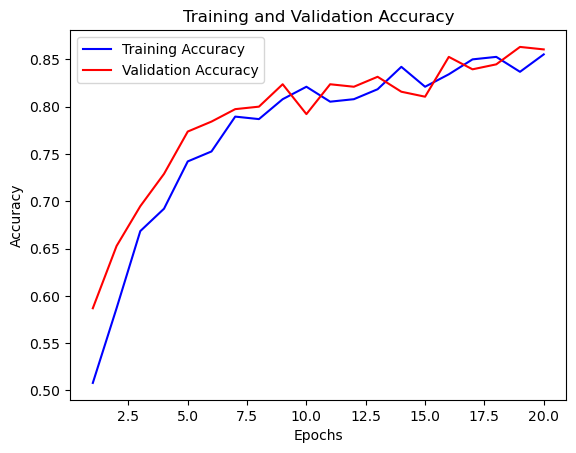

In [41]:
ans_model = AnswerabilityModel().to(device)
epoch = 20
optimizer_ans = torch.optim.Adam(ans_model.parameters(), 0.00001, weight_decay=.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ans, patience=5, factor=.3, threshold=1e-4)
train_accuracy_per_epoch = []
train_loss_per_epoch = []

val_accuracy_per_epoch = []
val_loss_per_epoch = []


for e in range(epoch):
    print("\n\nEpoch #", e+1)
    count_train = 0
    count_val = 0
    
    ans_pred_train, ans_ground_train, loss_train = run_answerability_model(ans_model,train_dataloader_ans,optimizer_ans,True)
    ans_pred_val, ans_ground_val, loss_val = run_answerability_model(ans_model,val_dataloader_ans,optimizer_ans,False)

    print("Training Loss = ", loss_train)
    
    ans_pred_train = [int(x) for x in ans_pred_train]
    ans_ground_train = [int(x) for x in ans_ground_train]
    result = [x ^ y for x, y in zip(ans_pred_train, ans_ground_train)]
    count_train = result.count(0)
    train_accuracy = count_train / len(ans_pred_train)
    print("Training Accuracy = ", train_accuracy*100, '%') 
    
    train_accuracy_per_epoch.append(train_accuracy)
    train_loss_per_epoch.append(loss_train)
    
    
    
    print("\nValidation Loss = ", loss_val)
    
    ans_pred_val = [int(x) for x in ans_pred_val]
    ans_ground_val = [int(x) for x in ans_ground_val]
    result = [x ^ y for x, y in zip(ans_pred_val, ans_ground_val)]
    count_val = result.count(0)
    val_accuracy = count_val/len(ans_pred_val)
    print("Validation Accuracy = ", val_accuracy*100, '%')   
    
    val_accuracy_per_epoch.append(val_accuracy)
    val_loss_per_epoch.append(loss_val)
    

# Create a range of epochs
epochs = range(1, len(train_accuracy_per_epoch)+1)

# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy_per_epoch, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_per_epoch, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Testing

In [42]:
count_test = 0

answers_predictions_test, ground_truth_answer_test, loss_test = run_answerability_model(ans_model,test_dataloader,optimizer_ans,True)

print("Testing Loss = ", loss_test)

ans_pred_test = [int(x) for x in answers_predictions_test]
ans_ground_test = [int(x) for x in ground_truth_answer_test]
result = [x ^ y for x, y in zip(ans_pred_test, ans_ground_test)]
count_test = result.count(0)
test_accuracy = count_test/len(ans_pred_test)
print("Testing Accuracy = ", test_accuracy*100, '%')   

Testing Loss =  63.997436908246286
Testing Accuracy =  87.36842105263159 %
